# PCA + OLS estimation: DFM
---

> A partir dos componentes principais, que são os estimadores dos fatores, extraídos no script 'dfm_pca.ipynb', podemos estimar o primeiro modelo por MQO, em uma regressão do PIB em k fatores.

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt

## Carregando os dados 

In [2]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()
qgdp

Date
2002Q1     NaN
2002Q2    4.78
2002Q3    4.09
2002Q4   -0.26
2003Q1   -5.66
          ... 
2021Q3    3.62
2021Q4   -0.97
2022Q1   -1.02
2022Q2    3.89
2022Q3     NaN
Freq: Q-DEC, Name: gdp, Length: 83, dtype: float64

In [3]:
# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")
data_pca

C:\Users\HENRI\AppData\Local\Temp\ipykernel_14656\3990215449.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,-0.035760,0.278165,-0.193502,0.410918,0.457077,0.124111,-4.086839,-0.211029,-2.015821,0.153924,...,-0.015650,-0.018741,-0.012488,-0.003355,-0.001820,0.002867,-0.002014,0.003936,0.001473,0.002299
2002-02-01,1.361523,0.543296,-1.084225,-1.771966,1.736007,-1.764482,-3.243848,-0.572778,-2.048222,0.460323,...,0.015028,-0.004960,-0.005318,-0.000229,0.001145,-0.002313,-0.000339,-0.000706,-0.000039,-0.000216
2002-03-01,-2.858910,-2.429927,-0.006000,-0.117893,-0.364701,1.200478,-3.434669,0.814006,-1.937335,-0.036418,...,0.005791,-0.004337,0.005570,-0.002036,-0.000532,-0.003687,-0.000451,0.000278,-0.000561,-0.000051
2002-04-01,-0.325402,-1.515396,-1.156760,0.047297,-0.082319,-0.355296,-3.100363,-1.170952,-1.886274,0.864904,...,-0.008699,0.007453,0.006258,-0.001742,-0.001822,-0.002317,-0.000789,0.000755,-0.000729,-0.000270
2002-05-01,0.036953,0.210243,0.455721,-0.495949,1.218162,-0.325442,-2.142345,-0.377686,-2.227995,-2.347546,...,-0.001067,-0.006744,-0.010863,-0.005787,0.009163,0.003214,0.000488,0.000253,0.000308,-0.000192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,-5.536711,-3.788205,2.879354,1.226408,0.869925,0.089662,-0.829625,-1.160846,0.797622,-6.047055,...,0.015520,-0.004843,0.000498,0.016976,-0.000011,-0.003062,-0.002824,-0.000030,0.000224,0.000251
2022-06-01,1.250343,1.864334,0.100853,0.236173,3.478056,3.325545,-0.674530,0.907224,5.583242,-2.380426,...,0.008901,0.004705,0.004506,0.012952,0.002310,-0.004012,-0.002869,0.000232,0.000197,-0.000251
2022-07-01,-1.576685,-1.544646,0.533441,-3.890632,-3.721917,0.855544,0.280945,-0.453929,-4.103574,0.971140,...,-0.004301,0.001744,0.005154,-0.005083,0.000276,0.000581,0.002657,0.000066,-0.000652,-0.000106


## Preparando as variáveis

In [4]:
# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153
Date,,,,,,,,,,,,,,,,,,,,,
2002Q1,0.52,-0.511049,-0.536155,-0.427909,-0.492980,0.609461,-0.146631,-3.588452,0.010066,-2.000459,...,0.001723,-0.009346,-0.004079,-0.001873,-0.000402,-0.001044,-0.000934,0.001169,0.000291,0.000678
2002Q2,4.78,0.457744,0.040322,0.088390,-0.107263,0.764068,-0.280766,-2.131350,-0.450610,-2.812180,...,-0.004888,-0.003039,0.001973,0.000228,0.002483,0.000309,-0.000309,0.000023,-0.000188,-0.000222
2002Q3,4.09,-0.415919,0.633470,0.444516,4.372096,1.576875,-1.178563,-2.691229,-2.714884,-1.273962,...,0.007636,0.004437,0.001226,0.003872,0.002478,-0.001747,0.001217,-0.000035,-0.000071,-0.000008
2002Q4,-0.26,0.176772,2.303307,-4.390826,12.468848,3.480151,-0.463652,-2.696458,-1.990016,-2.587436,...,-0.007489,-0.001239,0.001916,-0.001769,-0.001986,-0.000136,-0.001161,-0.000029,0.000005,-0.000153
2003Q1,-5.66,1.986431,-0.782518,-2.232472,6.396720,1.758695,0.110951,-4.414169,0.513566,-1.813640,...,0.006419,0.000129,-0.007210,0.000538,-0.000865,0.000579,0.000660,-0.000111,0.000184,0.000181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q3,3.62,0.338923,-0.706513,-1.766068,2.533006,0.140524,-0.129285,1.413056,-0.459130,1.059980,...,0.003509,0.001671,-0.004738,-0.001248,-0.002824,-0.002495,-0.000968,-0.000024,-0.000044,-0.000051
2021Q4,-0.97,-1.863777,3.446000,-1.442487,3.435640,-0.995528,0.865907,1.333896,-1.848209,-0.175712,...,-0.005792,-0.003820,-0.000497,0.000159,0.001903,0.002058,0.000447,-0.000340,0.000135,0.000147
2022Q1,-1.02,2.737765,-2.662154,0.841413,5.546028,0.865046,-1.221949,0.195704,2.557923,2.652885,...,-0.007212,-0.002582,-0.001923,-0.000816,-0.000692,-0.000907,-0.001288,0.000070,0.000131,-0.000083


In [5]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-06-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

In [6]:
# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [7]:
y_train

Date
2002Q1    0.52
2002Q2    4.78
2002Q3    4.09
2002Q4   -0.26
2003Q1   -5.66
          ... 
2016Q4   -3.15
2017Q1   -0.06
2017Q2    2.71
2017Q3    3.22
2017Q4   -1.71
Freq: Q-DEC, Name: gdp, Length: 64, dtype: float64

# Modelos
---

## 1. DFM: regressão linear por MQO - 5 fatores utilizados

In [8]:
X5_train = X_train[['F1', 'F2', 'F3', 'F4', 'F5']].copy()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = train)
dfm_ols_5fac = reg.fit()
print(dfm_ols_5fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     17.79
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           1.19e-10
Time:                        18:31:30   Log-Likelihood:                -147.41
No. Observations:                  64   AIC:                             306.8
Df Residuals:                      58   BIC:                             319.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6450      0.327      1.971      0.0

In [121]:
# X5_train = X_train[['F1', 'F2', 'F3', 'F4', 'F5']].copy()
# X5_train['intercept'] = 1

# reg = sm.OLS(endog = y_train, exog = X5_train)
# dfm_ols_5fac = reg.fit()
# print(dfm_ols_5fac.summary())

## 2. DFM: regressão linear MQO - 1 fator

In [122]:
reg = smf.ols('gdp ~ F1', data = train)
dfm_ols_1fac = reg.fit()
print(dfm_ols_1fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     12.84
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           0.000669
Time:                        15:50:58   Log-Likelihood:                -171.14
No. Observations:                  64   AIC:                             346.3
Df Residuals:                      62   BIC:                             350.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8333      0.446      1.869      0.0

In [123]:
# reg = sm.OLS(endog = y_train, exog = sm.add_constant(X5_train['F1']))
# dfm_ols_1fac = reg.fit()
# print(dfm_ols_1fac.summary())

## 3. DFM: 5 fatores, uma defasagem do PIB

In [11]:
train['gdp_1'] = train['gdp'].shift(1)

reg = smf.ols('gdp ~ gdp_1 + F1 + F2 + F3 + F4 + F5', data = train)
dfm_5fac_1lag = reg.fit()
print(dfm_5fac_1lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     15.34
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           2.66e-10
Time:                        18:32:08   Log-Likelihood:                -144.27
No. Observations:                  63   AIC:                             302.5
Df Residuals:                      56   BIC:                             317.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7761      0.338      2.299      0.0

C:\Users\HENRI\AppData\Local\Temp\ipykernel_14656\1418978568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['gdp_1'] = train['gdp'].shift(1)


## 4. DFM: 5 fatores, uma defasagem para cada fator e uma defasagem para o PIB

In [13]:
train['F1_1'] = train['F1'].shift(1)
train['F2_1'] = train['F2'].shift(1)
train['F3_1'] = train['F3'].shift(1)
train['F4_1'] = train['F4'].shift(1)
train['F5_1'] = train['F5'].shift(1)

reg = smf.ols('gdp ~ gdp_1 + F1 + F2 + F3 + F4 + F5 + F1_1 + F2_1 + F3_1 + F4_1 + F5_1', data = train)
dfm_5faclags_1lag = reg.fit()
print(dfm_5faclags_1lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     26.20
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           3.32e-17
Time:                        18:35:44   Log-Likelihood:                -115.20
No. Observations:                  63   AIC:                             254.4
Df Residuals:                      51   BIC:                             280.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7589      0.232      3.274      0.0

C:\Users\HENRI\AppData\Local\Temp\ipykernel_14656\1544081473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['F1_1'] = train['F1'].shift(1)
C:\Users\HENRI\AppData\Local\Temp\ipykernel_14656\1544081473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['F2_1'] = train['F2'].shift(1)
C:\Users\HENRI\AppData\Local\Temp\ipykernel_14656\1544081473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

## 5. DFM: 1 fator e uma defasagem do PIB

In [14]:
reg = smf.ols('gdp ~ gdp_1 + F1 + F1_1', data = train)
dfm_1faclag_1lag = reg.fit()
print(dfm_1faclag_1lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     10.11
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           1.81e-05
Time:                        18:37:06   Log-Likelihood:                -161.82
No. Observations:                  63   AIC:                             331.6
Df Residuals:                      59   BIC:                             340.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7903      0.432      1.829      0.0

# Salvando os SUMÁRIOS dos modelos

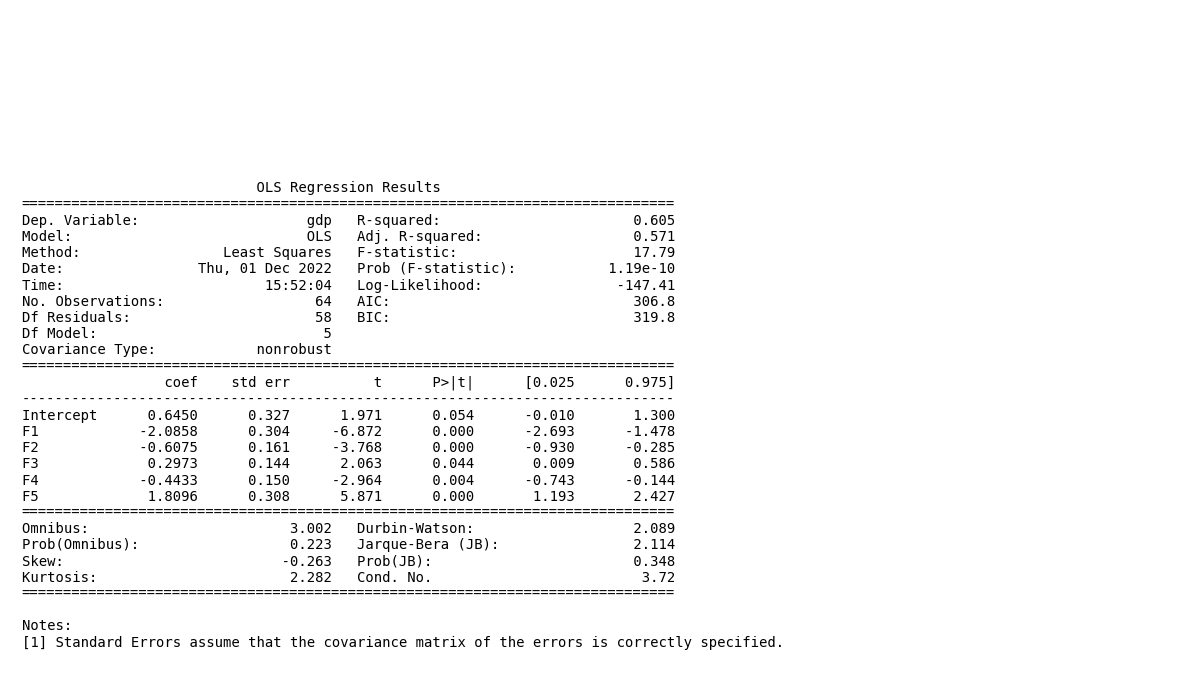

In [128]:
# DFM 5 fatores 

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(dfm_ols_5fac.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('dfm-images-plots/dfm5fac.png')

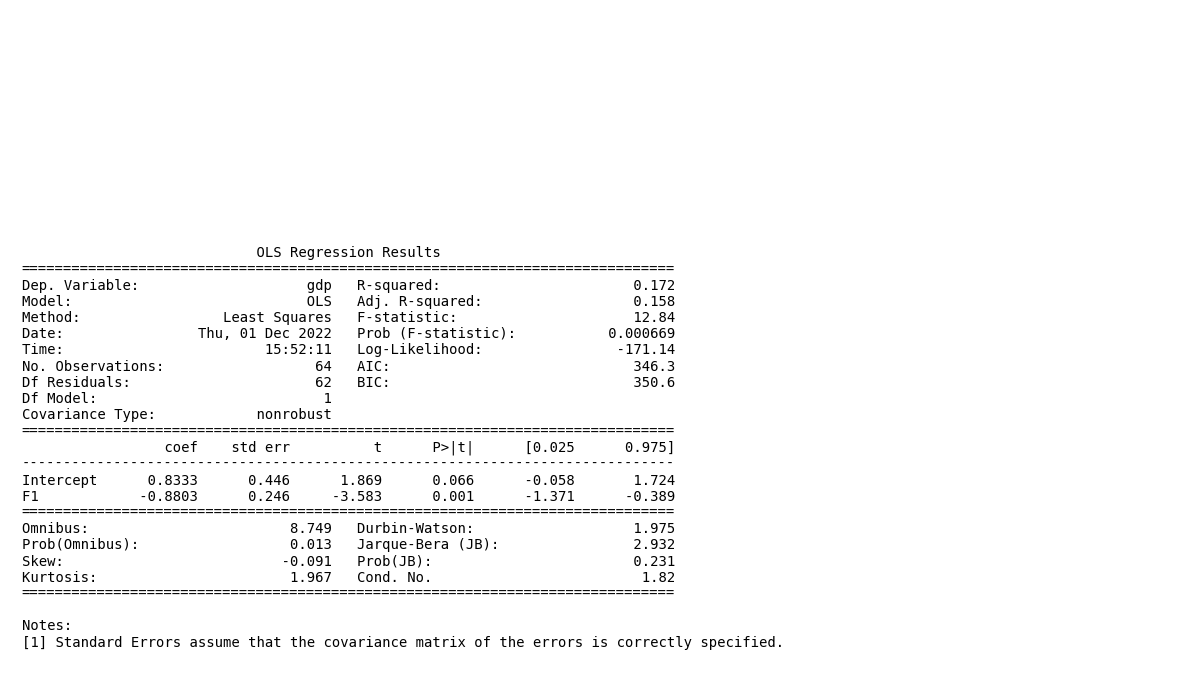

In [129]:
# DFM 1 fator 

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(dfm_ols_1fac.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('dfm-images-plots/dfm1fac.png')

# Gráficos das PREVISÕES